In [ ]:
import re

cols = df.columns.tolist()

def find_col(patterns):
    """patterns: list of regex patterns (case-insensitive)"""
    hits = []
    for c in cols:
        for p in patterns:
            if re.search(p, c, flags=re.I):
                hits.append(c)
                break
    return hits

age_hits = find_col([
    r"\bage\b", r"age_", r"_age", r"celebrity.*age", r"age.*during", r"年龄"
])

score_hits = find_col([
    r"\bscore\b", r"score_", r"_score", r"total.*score", r"judge.*score",
    r"season.*judge", r"judge.*total", r"points", r"rating", r"成绩", r"评委"
])




可能的年龄列： ['celebrity_age_during_season']
可能的成绩列： ['week1_judge1_score', 'week1_judge2_score', 'week1_judge3_score', 'week1_judge4_score', 'week2_judge1_score', 'week2_judge2_score', 'week2_judge3_score', 'week2_judge4_score', 'week3_judge1_score', 'week3_judge2_score', 'week3_judge3_score', 'week3_judge4_score', 'week4_judge1_score', 'week4_judge2_score', 'week4_judge3_score', 'week4_judge4_score', 'week5_judge1_score', 'week5_judge2_score', 'week5_judge3_score', 'week5_judge4_score', 'week6_judge1_score', 'week6_judge2_score', 'week6_judge3_score', 'week6_judge4_score', 'week7_judge1_score', 'week7_judge2_score', 'week7_judge3_score', 'week7_judge4_score', 'week8_judge1_score', 'week8_judge2_score', 'week8_judge3_score', 'week8_judge4_score', 'week9_judge1_score', 'week9_judge2_score', 'week9_judge3_score', 'week9_judge4_score', 'week10_judge1_score', 'week10_judge2_score', 'week10_judge3_score', 'week10_judge4_score', 'week11_judge1_score', 'week11_judge2_score', 'week11_judge3_score'

In [7]:
age_col = age_hits[0]
score_col = score_hits[0]


提取点数 = 44
r = 0.143
         age  score
0  42.037370   15.0
1  48.646010   15.0
2  59.288538   15.0
3  69.675937   15.0
4  27.577051   14.0


C:\Users\Jimmy Che\AppData\Local\Temp\ipykernel_50344\1603751723.py:169: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Jimmy Che\AppData\Local\Temp\ipykernel_50344\1603751723.py:169: UserWarning: Glyph 40836 (\N{CJK UNIFIED IDEOGRAPH-9F84}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Jimmy Che\AppData\Local\Temp\ipykernel_50344\1603751723.py:169: UserWarning: Glyph 25104 (\N{CJK UNIFIED IDEOGRAPH-6210}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Jimmy Che\AppData\Local\Temp\ipykernel_50344\1603751723.py:169: UserWarning: Glyph 32489 (\N{CJK UNIFIED IDEOGRAPH-7EE9}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Jimmy Che\AppData\Local\Temp\ipykernel_50344\1603751723.py:169: UserWarning: Glyph 19982 (\N{CJK UNIFIED IDEOGRAPH-4E0E}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Jimmy Che\AppData\Local\Temp\ipykernel_50344\1603751723.py:169: UserWarning: Glyph 20851 (\

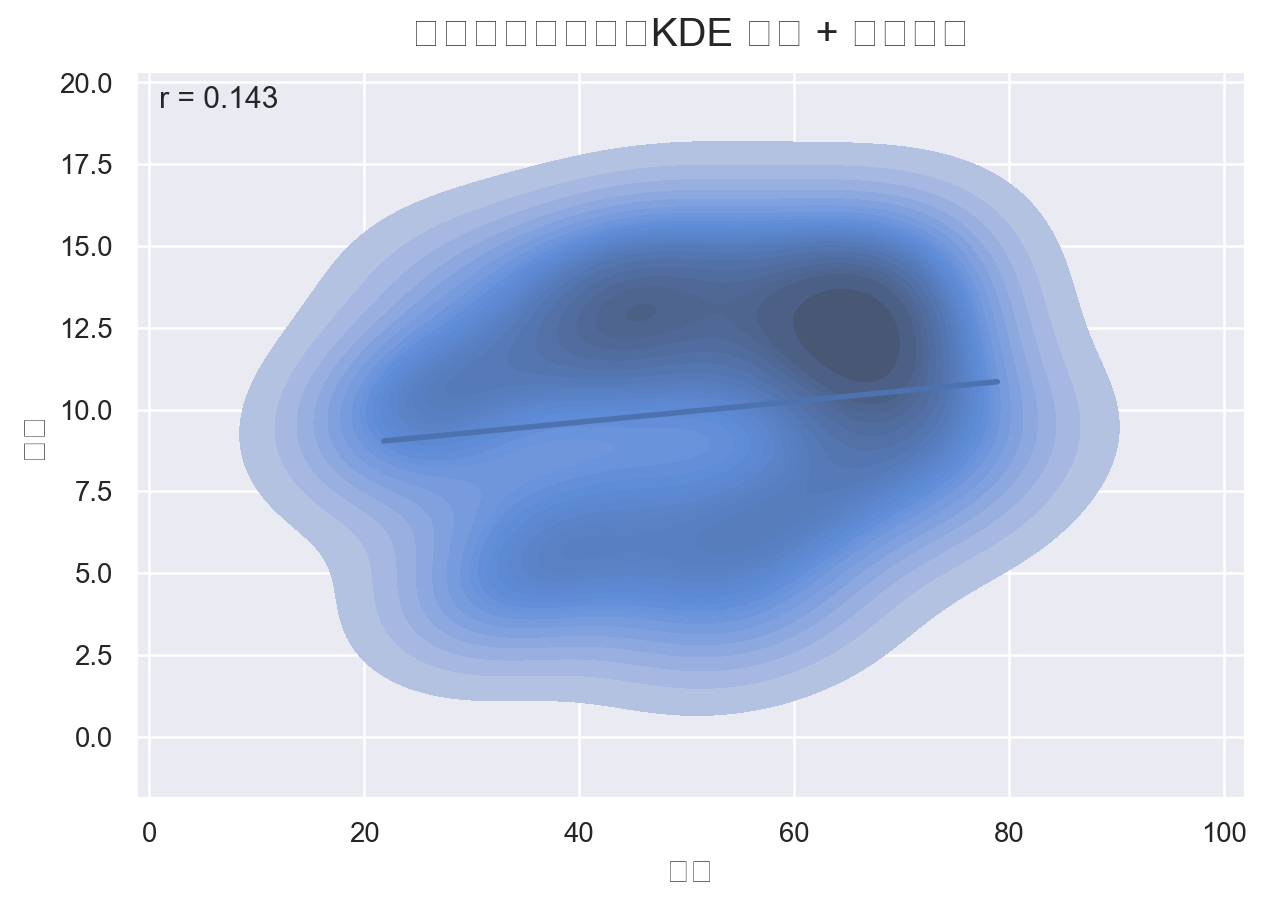

In [ ]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



X_MIN, X_MAX = 0, 100
Y_MIN, Y_MAX = 0, 16

PEAK_MIN_DIST = 6

KDE_LEVELS = 25
KDE_THRESH = 0.03
KDE_BW_ADJUST = 0.9

img_bgr = cv2.imread(IMG_PATH)
if img_bgr is None:
    raise FileNotFoundError(f"读不到图片：{IMG_PATH}")

h0, w0 = img_bgr.shape[:2]

if CROP is not None:
    x1, y1, x2, y2 = CROP
    roi = img_bgr[y1:y2, x1:x2].copy()
else:
    x1 = int(w0 * 0.12)
    x2 = int(w0 * 0.86)
    y1 = int(h0 * 0.18)
    y2 = int(h0 * 0.88)
    roi = img_bgr[y1:y2, x1:x2].copy()

H, W = roi.shape[:2]

roi_hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

lower = np.array([85, 40, 40])
upper = np.array([130, 255, 255])
mask = cv2.inRange(roi_hsv, lower, upper)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
mask = cv2.dilate(mask, kernel, iterations=1)

dist = cv2.distanceTransform(mask, cv2.DIST_L2, 5)
dist_norm = cv2.normalize(dist, None, 0, 1.0, cv2.NORM_MINMAX)

_, peaks = cv2.threshold(dist_norm, 0.35, 1.0, cv2.THRESH_BINARY)
peaks = (peaks * 255).astype(np.uint8)


num_labels, markers = cv2.connectedComponents(peaks)

roi_ws = roi.copy()
markers_ws = markers.astype(np.int32)
cv2.watershed(roi_ws, markers_ws)

points_px = []
ys, xs = np.where(markers_ws == lab)

cx = xs.mean()
cy = ys.mean()
points_px.append((cx, cy))

points_px = np.array(points_px, dtype=float)
if len(points_px) == 0:
    raise RuntimeError("没提取到散点。请调 CROP 或 HSV 阈值（lower/upper）。")

x_norm = points_px[:, 0] / (W - 1)
y_norm = points_px[:, 1] / (H - 1)

age = X_MIN + x_norm * (X_MAX - X_MIN)
score = Y_MAX - y_norm * (Y_MAX - Y_MIN)

score_round = np.clip(np.rint(score), Y_MIN, Y_MAX)

df_rec = pd.DataFrame({"age": age, "score": score_round})

df_rec = df_rec[(df_rec["age"] >= X_MIN) & (df_rec["age"] <= X_MAX)]
df_rec = df_rec[(df_rec["score"] >= Y_MIN) & (df_rec["score"] <= Y_MAX)]

r = df_rec["age"].corr(df_rec["score"])

print("提取点数 =", len(df_rec))
print("r =", round(r, 3))
print(df_rec.head())

plt.rcParams["font.sans-serif"] = ["Microsoft YaHei", "SimHei", "Arial Unicode MS"]
plt.rcParams["axes.unicode_minus"] = False

sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(7.2, 5.2), dpi=180)

df_rec["_score_jit"] = df_rec["score"] + np.random.normal(0, 0.12, size=len(df_rec))

sns.kdeplot(
    data=df_rec, x="age", y="_score_jit",
    fill=True,
    levels=KDE_LEVELS,
    thresh=KDE_THRESH,
    bw_adjust=KDE_BW_ADJUST,
    ax=ax
)

sns.regplot(
    data=df_rec, x="age", y="score",
    scatter=False,
    ci=None,
    line_kws={"linewidth": 2.2},
    ax=ax
)

ax.text(0.02, 0.98, f"r = {r:.3f}", transform=ax.transAxes,
        ha="left", va="top", fontsize=12)

ax.set_title("年龄与成绩关系（KDE 密度 + 回归线）", fontsize=16, pad=10)
ax.set_xlabel("年龄", fontsize=13)
ax.set_ylabel("成绩", fontsize=13)

plt.tight_layout()
plt.savefig("fig2_from_fig1.png", bbox_inches="tight")
plt.show()


Matplotlib actual font: ['Times New Roman']


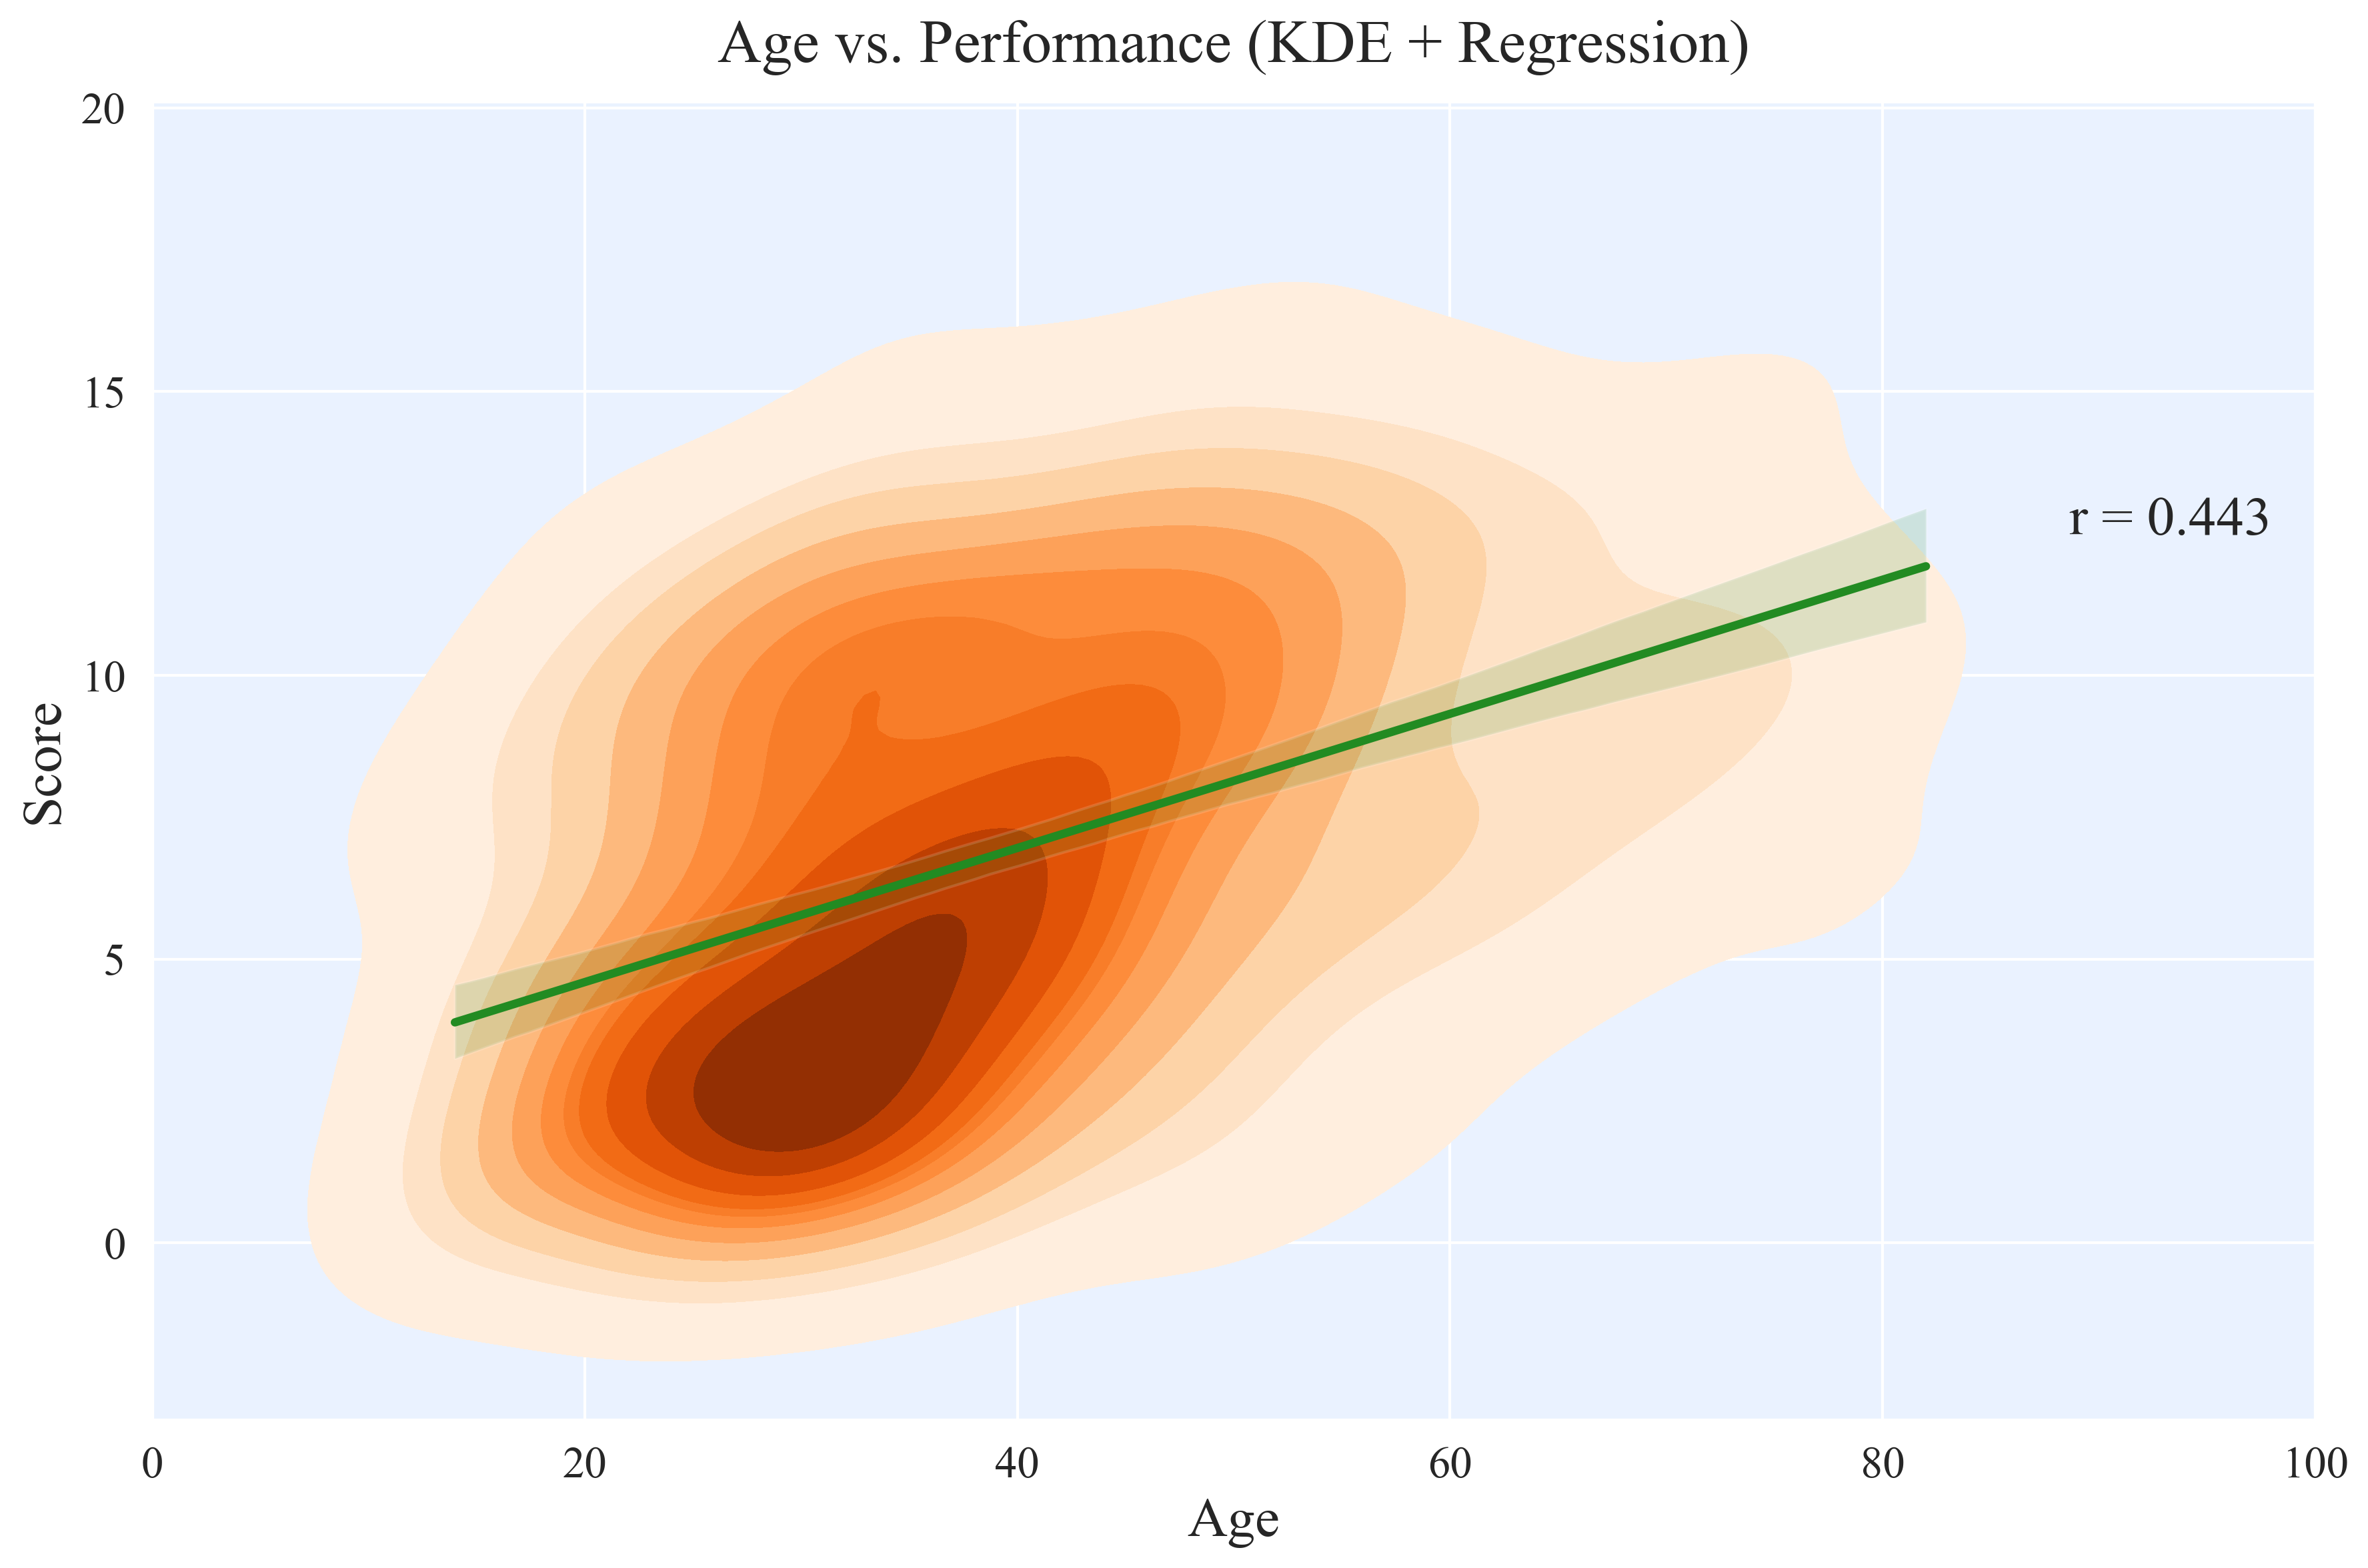

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl

mpl.rcParams["font.family"] = "Times New Roman"
mpl.rcParams["axes.unicode_minus"] = False



from scipy.stats import spearmanr, pearsonr

df = pd.read_csv("age_placement_for_python.csv")
df = df.dropna(subset=["age", "placement"])
df = df[(df["age"] > 0) & (df["placement"] > 0)]

r_s, _ = spearmanr(df["age"], df["placement"])
r_p, _ = pearsonr(df["age"], df["placement"])


mpl.rcParams["font.family"] = "Times New Roman"
mpl.rcParams["axes.unicode_minus"] = False


plt.figure(figsize=(12, 8), dpi=300)

ax = sns.kdeplot(
    data=df,
    x="age",
    y="placement",
)


sns.regplot(
    data=df, x="age", y="placement",
    scatter=False, ax=ax,
    line_kws={"linewidth": 3, "color": "#228B22"}

)


ax.set_title("Age vs. Performance (KDE + Regression)", fontsize=22, pad=14)
ax.set_xlabel("Age", fontsize=20)
ax.set_ylabel("Score", fontsize=20)

ax.text(
    0.98, 0.7,
    transform=ax.transAxes,
    fontsize=20,
    ha="right", va="top"
)

ax.tick_params(axis="both", which="major", labelsize=16)

ax.set_xlim(0, 100)



bg = "#EAF2FF"




plt.tight_layout()

print("Matplotlib actual font:", mpl.rcParams["font.family"])


plt.show()
